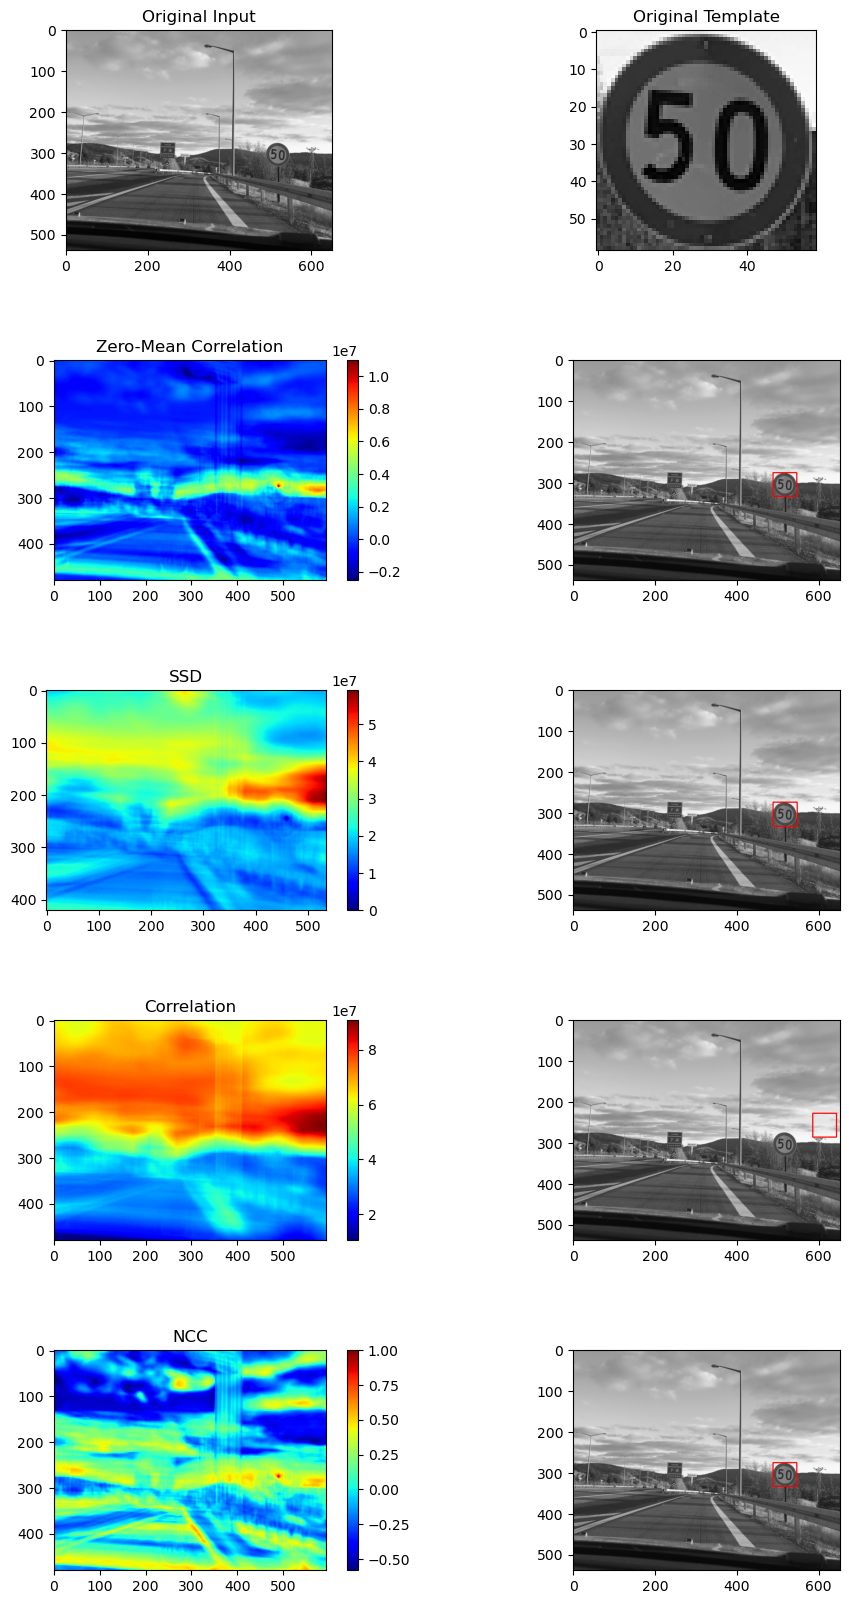

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


input_img = cv2.imread('input.png', cv2.IMREAD_GRAYSCALE)
template_img = cv2.imread('template.png', cv2.IMREAD_GRAYSCALE)

fig = plt.figure(figsize = (12, 20))

plt.subplot(5, 2, 1)
plt.title('Original Input')
plt.imshow(input_img, cmap = 'gray')

plt.subplot(5, 2, 2)
plt.title('Original Template')
plt.imshow(template_img, cmap = 'gray')


def correlationMeasure(P, T):
    P = np.float64(P)
    T = np.float64(T)
    return np.sum(np.multiply(P, T))


def zeroMeanCorrelationMeasure(P, T):
    P = np.float64(P)
    T = np.float64(T)
    mean_T = np.mean(T)
    T = T - mean_T
    return np.sum(np.multiply(P, T))

def sumOfSquaredDifferenceMeasure(P, T):
    P = np.float64(P)
    T = np.float64(T)
    return np.sum(np.square(P - T))

def normalizedCrossCorrelationMeasure(P, T):
    P = np.float64(P)
    T = np.float64(T)
    mean_P = np.mean(P)
    mean_T = np.mean(T)
    P = P - mean_P
    T = T - mean_T
    numerator = np.sum(np.multiply(P, T))
    denominator = np.sqrt(np.sum(np.square(P)) * np.sum(np.square(T)))
    return numerator / denominator

a, b = template_img.shape[0] // 2, template_img.shape[1] // 2

def template_matching(input_img, template_img, measure):

    matching_scores = np.zeros((input_img.shape[0] + 2*a, input_img.shape[1] + 2*b))
    matching_scores[a:-a, b:-b] = -np.inf

    for i in range(a, input_img.shape[0]-a):
        for j in range(b, input_img.shape[1]-b):
            patch = input_img[i-a:i+a+1, j-b:j+b+1]
            matching_scores[i+a, j+b] = measure(patch, template_img)

    matching_scores = matching_scores[a:-a, b:-b]

    return matching_scores

    
    

corr_scores = template_matching(input_img, template_img, correlationMeasure)
zm_corr_scores = template_matching(input_img, template_img, zeroMeanCorrelationMeasure)
norm_x_corr_scores = template_matching(input_img, template_img, normalizedCrossCorrelationMeasure)

# Find the maximum and minimum correlation scores and their locations using cv2.minMaxLoc()
_, max_corr, _, max_corr_loc = cv2.minMaxLoc(corr_scores)
_, max_zm_corr, _, max_zm_corr_loc = cv2.minMaxLoc(zm_corr_scores)
_, max_norm_x_corr, _, max_norm_x_corr_loc = cv2.minMaxLoc(norm_x_corr_scores)


# Check if the maximum location is a tuple if true, extract the coordinates
if isinstance(max_corr_loc, tuple):
    max_corr = (max_corr_loc[1], max_corr_loc[0])
if isinstance(max_zm_corr_loc, tuple):
    max_zm_corr = (max_zm_corr_loc[1], max_zm_corr_loc[0])
if isinstance(max_norm_x_corr_loc, tuple):
    max_norm_x_corr = (max_norm_x_corr_loc[1], max_norm_x_corr_loc[0])


input_ssd=input_img.copy()
template_ssd=template_img.copy()

ssdScore=np.zeros((input_ssd.shape[0]-template_ssd.shape[0], input_ssd.shape[1]-template_ssd.shape[1]))

for i in range(ssdScore.shape[0]):
    for j in range(ssdScore.shape[1]):
        ssdScore[i,j]=sumOfSquaredDifferenceMeasure(input_ssd[i:i+template_ssd.shape[0], j:j+template_ssd.shape[1]], template_ssd)
        
minVal, maxVal, minLoc, maxLoc=cv2.minMaxLoc(ssdScore)
minX, minY=minLoc
maxX, maxY=maxLoc

rectangle_ssd=np.zeros((input_ssd.shape[0]-template_ssd.shape[0], input_ssd.shape[1]-template_ssd.shape[1]))
for i in range(rectangle_ssd.shape[0]):
    for j in range(rectangle_ssd.shape[1]):
        rectangle_ssd[i,j]=sumOfSquaredDifferenceMeasure(input_ssd[i:i+template_ssd.shape[0], j:j+template_ssd.shape[1]], template_ssd)


input_img_rgb = cv2.cvtColor(input_img, cv2.COLOR_GRAY2RGB)
input_ssd_rgb = cv2.cvtColor(input_img, cv2.COLOR_GRAY2RGB)
input_img_max_corr = cv2.rectangle(input_img_rgb.copy(), (max_corr[1]-b, max_corr[0]-a), (max_corr[1]+b, max_corr[0]+a), (255, 0, 0), 2)
input_img_max_zm_corr = cv2.rectangle(input_img_rgb.copy(), (max_zm_corr[1]-b, max_zm_corr[0]-a), (max_zm_corr[1]+b, max_zm_corr[0]+a), (255, 0, 0), 2)
input_img_max_norm_x_corr = cv2.rectangle(input_img_rgb.copy(), (max_norm_x_corr[1]-b, max_norm_x_corr[0]-a), (max_norm_x_corr[1]+b, max_norm_x_corr[0]+a), (255, 0, 0), 2)

minVal, maxVal, minLoc, maxLoc=cv2.minMaxLoc(rectangle_ssd)
maxX, maxY=maxLoc

rectangle_ssd=template_ssd.shape[:2][::-1]

input_img_min_ssd=cv2.rectangle(input_ssd_rgb, (minX, minY), (minX+rectangle_ssd[0], minY+rectangle_ssd[1]), (255,0,0), 2)

plt.subplot(5, 2, 3)
zm_corr_scores_plt = plt.imshow(zm_corr_scores[a:-a, b:-b], cmap = 'jet')
plt.title('Zero-Mean Correlation')
plt.colorbar(zm_corr_scores_plt)

plt.subplot(5, 2, 4)
plt.imshow(input_img_max_zm_corr)




plt.subplot(5, 2, 5)
ssd_scores_plt = plt.imshow(ssdScore[a:-a, b:-b], cmap = 'jet')
plt.title('SSD')
plt.colorbar(ssd_scores_plt)

plt.subplot(5, 2, 6)
plt.imshow(input_img_min_ssd)





plt.subplot(5, 2, 7)
corr_scores_plt = plt.imshow(corr_scores[a:-a, b:-b], cmap = 'jet')
plt.title('Correlation')
plt.colorbar(corr_scores_plt)

plt.subplot(5, 2, 8)
plt.imshow(input_img_max_corr)




plt.subplot(5, 2, 9)
norm_x_corr_scores_plt = plt.imshow(norm_x_corr_scores[a:-a, b:-b], cmap = 'jet')
plt.title('NCC')
plt.colorbar(norm_x_corr_scores_plt)

plt.subplot(5, 2, 10)
plt.imshow(input_img_max_norm_x_corr)
plt.subplots_adjust(hspace=0.5)
plt.show()
